In [22]:
import numpy as np
import tensorflow as tf
import pandas as pd
import spacy
from matplotlib import pyplot

In [ ]:
from num2words import num2words

In [2]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from keras import layers

In [6]:
df = pd.read_csv('../Datasets/train/steam_ds_preprocessed.csv')

In [7]:
df = df[df.user_review.isna() == False]

In [ ]:
df.head()

In [8]:
df[['user_suggestion']].value_counts()

user_suggestion
Positive           9966
Negative           7523
dtype: int64

In [ ]:
## Preprocessing

In [9]:
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

In [10]:
df['user_review'] = df['user_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [11]:
df['user_review'] = df['user_review'].str.replace('[^\w\s]','')

C:\Users\sh_af\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
def lemma(text):
    doc=nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [ ]:
def stopword(text):
    doc=nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

In [ ]:
df['user_review'] = df['user_review'].apply(lemma)

In [ ]:
df['user_review'] = df['user_review'].apply(stopword)

In [12]:
document = df[['user_review']]
sentiment = df[['user_suggestion']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(document,  sentiment, test_size=0.20, random_state=42)

In [14]:
sentiment_label = y_train.user_suggestion.factorize()
sentiment_label_test = y_test.user_suggestion.factorize()

In [15]:
review = X_train.user_review.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [16]:
# Time based decay learning rate
initial_learning_rate = 0.001
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [17]:
callback = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)

In [18]:
adam_opt = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

In [19]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=adam_opt, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           1573056   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 1,589,707
Trainable params: 1,589,707
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
history = model.fit(padded_sequence,sentiment_label[0],
                  validation_split=0.2, epochs=100, batch_size=32, callbacks=[callback])

Epoch 1/100
350/350 [==============================] - 76s 213ms/step - loss: 0.5402 - accuracy: 0.7124 - val_loss: 0.4116 - val_accuracy: 0.8189
Epoch 2/100
350/350 [==============================] - 67s 192ms/step - loss: 0.3612 - accuracy: 0.8437 - val_loss: 0.3929 - val_accuracy: 0.8289
Epoch 3/100
350/350 [==============================] - 66s 188ms/step - loss: 0.3107 - accuracy: 0.8720 - val_loss: 0.4107 - val_accuracy: 0.8317
Epoch 4/100
350/350 [==============================] - 68s 195ms/step - loss: 0.2743 - accuracy: 0.8905 - val_loss: 0.4083 - val_accuracy: 0.8332
Epoch 5/100
350/350 [==============================] - 67s 191ms/step - loss: 0.2525 - accuracy: 0.8972 - val_loss: 0.4412 - val_accuracy: 0.8346
Epoch 6/100
350/350 [==============================] - 65s 187ms/step - loss: 0.2286 - accuracy: 0.9100 - val_loss: 0.4362 - val_accuracy: 0.8207
Epoch 7/100
350/350 [==============================] - 66s 188ms/step - loss: 0.2047 - accuracy: 0.9213 - val_loss: 0.4740 -

350/350 [==============================] - 69s 196ms/step - loss: 0.0339 - accuracy: 0.9892 - val_loss: 1.2587 - val_accuracy: 0.8017
Epoch 57/100
350/350 [==============================] - 70s 201ms/step - loss: 0.0314 - accuracy: 0.9892 - val_loss: 1.1734 - val_accuracy: 0.8010
Epoch 58/100
350/350 [==============================] - 75s 213ms/step - loss: 0.0304 - accuracy: 0.9895 - val_loss: 1.3146 - val_accuracy: 0.8014
Epoch 59/100
350/350 [==============================] - 76s 219ms/step - loss: 0.0392 - accuracy: 0.9864 - val_loss: 1.1556 - val_accuracy: 0.7999
Epoch 60/100
350/350 [==============================] - 81s 231ms/step - loss: 0.0341 - accuracy: 0.9880 - val_loss: 1.1353 - val_accuracy: 0.7921
Epoch 61/100
350/350 [==============================] - 75s 214ms/step - loss: 0.0378 - accuracy: 0.9867 - val_loss: 1.1151 - val_accuracy: 0.7992
Epoch 62/100
350/350 [==============================] - 80s 229ms/step - loss: 0.0340 - accuracy: 0.9873 - val_loss: 1.1950 - val_a

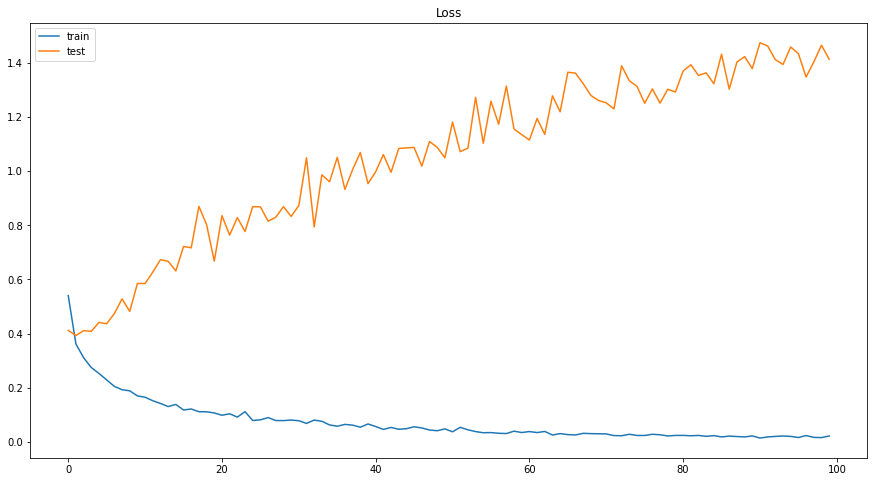

In [30]:
# plot loss during training
#pyplot.subplot(211)
fig=pyplot.figure(figsize=(15, 8))
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
fig.savefig("Loss.pdf")
pyplot.show()


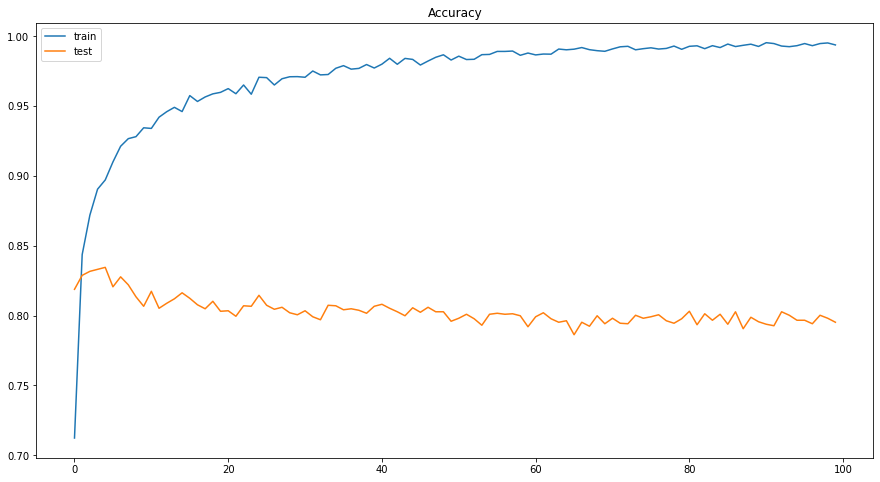

In [31]:
# plot accuracy during training
#pyplot.subplot(212)
fig_=pyplot.figure(figsize=(15, 8))
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
fig_.savefig("Accuracy.pdf")
pyplot.show()


In [ ]:
sentiment_label[1]

In [34]:
predicted_values = []

In [32]:
test_review = tokenizer.texts_to_sequences(X_test.user_review.values)
padded_sequence_test = pad_sequences(test_review, maxlen=200)

In [33]:
prediction = int(model.predict(padded_sequence_test).round().item())

ValueError: can only convert an array of size 1 to a Python scalar

In [35]:
for review in X_test.user_review.values:
    #review_test = X_test.user_review.values
    test_review = tokenizer.texts_to_sequences([review])
    padded_sequence_test = pad_sequences(test_review, maxlen=200)
    #print(padded_sequence_test)
    prediction = int(model.predict(padded_sequence_test).round().item())
    predicted_values.append(prediction)

In [ ]:
len(predicted_values)

In [ ]:
sentiment_label_test[0]

In [36]:
accuracy = round(accuracy_score(sentiment_label_test[0],predicted_values), 3)

In [40]:
recall = round(recall_score(sentiment_label_test[0],predicted_values), 3)

In [37]:
print(accuracy)

0.811


In [41]:
print(recall)

0.762
